In [1]:
from utils import Preprocessor
from nn import NNClassifier
import tensorflow as tf
import numpy as np

embedding_path = '../data/w2v.pickle'
train_path = '~juinanyen/MWP_Data/TrainSetv2'
valid_path = '~juinanyen/MWP_Data/DevSetv2'

preprocessor = Preprocessor(embedding_path)
train = preprocessor.load_data(train_path)
valid = preprocessor.load_data(valid_path)

with tf.device('/cpu:0'):
    clf = NNClassifier(valid=valid,
                       embedding=preprocessor.embedding)    
    clf.fit(train['x'], train['y'])

INFO:tensorflow:Restoring parameters from checkpoint/session-11


In [2]:
op = clf._session.graph.get_operations()
[m.values() for m in op]



[(<tf.Tensor 'global_step/initial_value:0' shape=() dtype=int32>,),
 (<tf.Tensor 'global_step:0' shape=() dtype=int32_ref>,),
 (<tf.Tensor 'global_step/Assign:0' shape=() dtype=int32_ref>,),
 (<tf.Tensor 'global_step/read:0' shape=() dtype=int32>,),
 (<tf.Tensor 'Placeholder:0' shape=(?, 2, 55) dtype=int32>,),
 (<tf.Tensor 'Placeholder_1:0' shape=(?, 5) dtype=int32>,),
 (<tf.Tensor 'nn/Const:0' shape=(517015, 300) dtype=float32>,),
 (<tf.Tensor 'nn/strided_slice/stack:0' shape=(3,) dtype=int32>,),
 (<tf.Tensor 'nn/strided_slice/stack_1:0' shape=(3,) dtype=int32>,),
 (<tf.Tensor 'nn/strided_slice/stack_2:0' shape=(3,) dtype=int32>,),
 (<tf.Tensor 'nn/strided_slice:0' shape=(?, 55) dtype=int32>,),
 (<tf.Tensor 'nn/embedding_lookup:0' shape=(?, 55, 300) dtype=float32>,),
 (<tf.Tensor 'nn/strided_slice_1/stack:0' shape=(3,) dtype=int32>,),
 (<tf.Tensor 'nn/strided_slice_1/stack_1:0' shape=(3,) dtype=int32>,),
 (<tf.Tensor 'nn/strided_slice_1/stack_2:0' shape=(3,) dtype=int32>,),
 (<tf.Tens

In [3]:
q_index = 5
x = clf._session.graph.get_tensor_by_name('Placeholder:0')
n_1 = tf.reduce_sum(tf.cast(tf.not_equal(x[:, 0, :], 0), tf.int32))

sim_score = clf._session.graph.get_tensor_by_name('nn/MatMul:0')

# attention_weight = tf.nn.softmax(sim_score, dim=1)
attention_weight = clf._session.graph.get_tensor_by_name('nn/attention_weight:0')

t_mask = clf._session.graph.get_tensor_by_name('nn/mask:0')

t_sim = clf._session.graph.get_tensor_by_name('nn/MatMul:0')

t_ob = clf._session.graph.get_tensor_by_name('nn/Body_GRU/output_b:0')


# t_att_w = tf.exp(similarity) * mask

r1, mask, similarity, ob = clf._session.run([attention_weight, t_mask, t_sim, t_ob], 
                                               {x: valid['x'][q_index: q_index + 1]})

np.sum(r1 * ob, axis=1)


array([[-0.09822773, -0.00331038, -0.03130637, -0.2039102 ,  0.01716874,
        -0.12184468, -0.03649157,  0.10800628, -0.09863895,  0.07535608,
         0.12301385, -0.08837609, -0.23118795, -0.03216997, -0.1280953 ,
         0.05611999,  0.11296335,  0.02367673,  0.11358768,  0.0231605 ,
        -0.08333876,  0.08265043,  0.03688541,  0.01923547, -0.07732403,
        -0.07801677, -0.04723826, -0.00791227,  0.08607736, -0.13872315,
        -0.11324041, -0.08001485, -0.13491763,  0.03001898,  0.00388129,
         0.03905027, -0.03508306,  0.08206839, -0.02612552, -0.11809225,
        -0.12375248, -0.14130273,  0.03505797, -0.06467507, -0.13732938,
         0.07330798, -0.09524103, -0.00660846, -0.09201357, -0.06886481,
        -0.13978711,  0.18061459, -0.02594151,  0.02880936,  0.16173992,
        -0.08058621, -0.16807134,  0.02198183, -0.0853283 , -0.01468283,
         0.02990085,  0.01664644,  0.06780195, -0.03266992,  0.02965128,
        -0.02788217,  0.0589643 , -0.06485711, -0.0

In [4]:
rev_dict = {}
for w, ind in preprocessor.word_dict.items():
    rev_dict[ind] = w

def to_text(inds, rev_dict):
    return [rev_dict[i] for i in inds]


/home/tinray/tf/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/tinray/tf/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


('平', 0.23148234)
('平', 0.25028965)
('家', 0.13030712)
('有', 0.094919905)
('隻', 0.048462398)
('小', 0.038874969)
('狗', 0.028333616)
('送', 0.038041551)
('走', 0.030592872)
('隻', 0.042844325)
('後', 0.065851279)


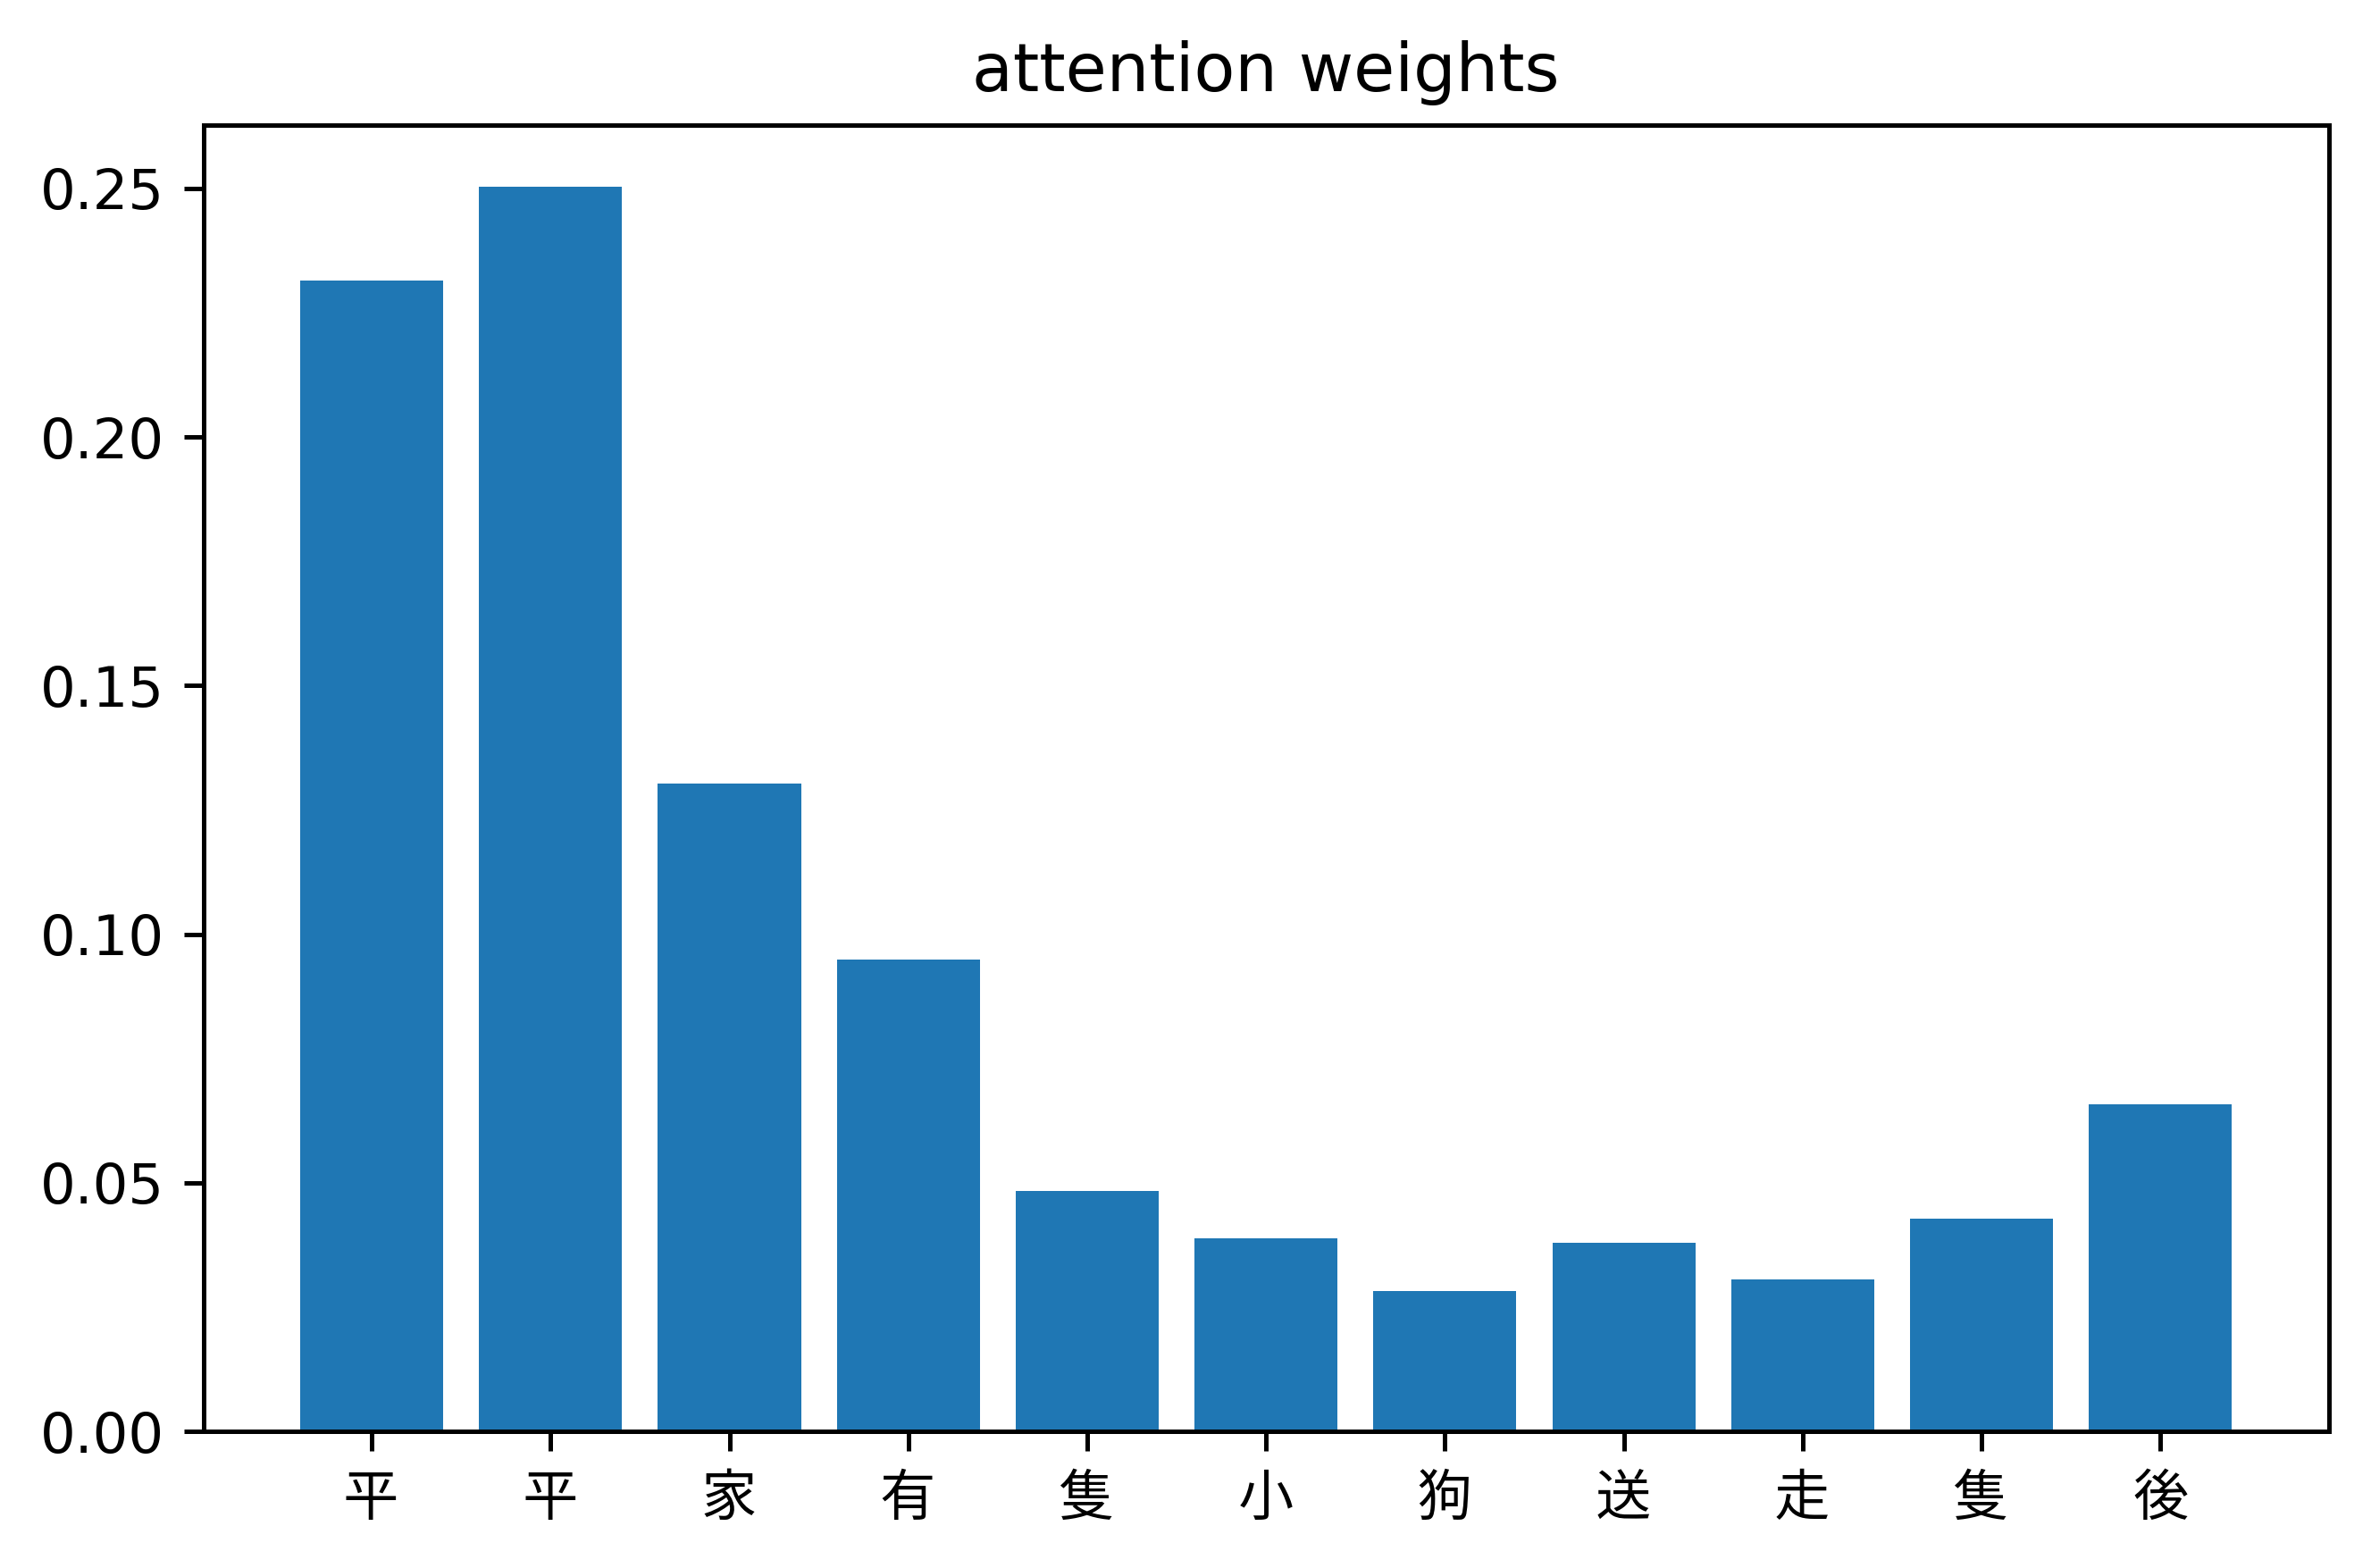

In [5]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np


path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
prop = matplotlib.font_manager.FontProperties(fname=path)

weights = r1.reshape(-1,)[:int(np.sum(np.sign(r1)))]
t = to_text(valid['x'][q_index][0], rev_dict)
for l in zip(t, weights):
    print(l)

fig = plt.figure(dpi=450)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('attention weights')

ax.bar(range(len(weights)), weights)
ax.set_xticks(np.arange(len(weights)))
ax.set_xticklabels(t, rotation=0, fontproperties=prop)


fig.tight_layout()


fig.show()

In [6]:


a = tf.constant([-0.1, -0.2, 0, 0, 0])

with tf.Session() as sess:
    res = sess.run(tf.nn.softmax(a))
    print(res)

[ 0.19155805  0.17332889  0.21170437  0.21170437  0.21170437]


In [7]:
i0 = tf.constant(0)
m0 = tf.ones([2, 2])
c = lambda i, m: i < 10
b = lambda i, m: [i+1, tf.concat([m, m], axis=0)]
res = tf.while_loop(
    c, b, loop_vars=[i0, m0],
    shape_invariants=[i0.get_shape(), tf.TensorShape([None, 2])])

with tf.Session() as sess:
    r = sess.run(res)

In [8]:
clf.predict(valid['x'][5:6])

array([[0, 0, 0, 1, 0]], dtype=int32)